## Predicting Heart Disease Project

According to the information from the World Health Organization (WHO), 17.9 million people die because of cardiovascular diseases (CVDs) every single year. 

However, identifying the risk factors that contribute to CVD can actually help with the prevention of many premature deaths. 
Therefore, we will use the anonymized data from multiple hospitals on different patients, and we will predict the likelihood of a new patient whether or not having a heart disease in the future. 

I will use the [Kaggle Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and make a K-Nearest Neighbors classifier.

In [25]:
#import libraries first
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC 
from sklearn.metrics import accuracy_score

import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 

### EDA: Descriptive Statistics

First, we started with importing libraries that we are going to need. And go on with the exporting file to observe the data. So, each patient have the collected information below:

- **Age**: Age of the patient (years)
- **Sex**: Sex of the patient (M: Male, F: Female)
- **ChestPainType**: Chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
- **RestingBP**: Resting blood pressure (mm Hg)
- **Cholesterol**: Serum cholesterol (mm/dl)
- **FastingBS**: Fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
- **RestingECG**: Resting electrocardiogram results
- **MaxHR**: Maximum heart rate achieved (Numeric value between 60 and 202)
- **ExerciseAngina**: Exercise-induced angina (Y: Yes, N: No)
- **Oldpeak**: Oldpeak = ST (Numeric value measured in depression)
- **ST_Slope**: The slope of the peak exercise ST segment
- **HeartDisease**: Output class (1: heart disease, 0: Normal)
  

In [27]:
#load the dataset
heart_df = pd.read_csv('heart.csv.xls')
heart_df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

Data consists of 12 different types of variables. It seems like both categorical and numerical as we expected. Let's look at the shape of the dataset and datatype for each column.

In [29]:
heart_df.shape

(918, 12)

In [30]:
print(heart_df.dtypes)
heart_df.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
Name: count, dtype: int64

While 5 of the features are categorical, the other 7 are numerical. On the other hand, HeartDisease and FastingBS are actually categorical as well because of the information type. 

Let's focus on numerical values first.

In [32]:
heart_df.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

Now we can see from the table above;

- Average age of the patients is **53** years.
- The median of **Cholesterol** is higher than its mean by roughly 25 mm/dl that shows us it could be left-skewed distribution with a possibility of outliers.
- RestingBP and Cholesterol have a minimum value of zero.
- It seems like there is no missing values in any of the columns for the table above. However we have to confirm it for the entire dataset.

RestingBP cannot be zero. And also, cholesterol is a composite of different measurements. Therefore, it is unlikely that Cholesterol would be zero as well. We should make a data cleaning for those later on.

Furthermore, there are categorical variables that we should look into. Also, relation of those categories with HeartDisease is important to look at. 

Before diving into that, let's look at the dataset to check if there is any missing values.

In [34]:
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Well, there are no missing values at all in this dataset!

### EDA: Categorical Data 

Categorical columns are mostly dtype **object**.

In [37]:
heart_df.describe(include=['object'])

Sex ChestPainType RestingECG ExerciseAngina ST_Slope
count   918           918        918            918      918
unique    2             4          3              2        3
top       M           ASY     Normal              N     Flat
freq    725           496        552            547      460

We can see that these columns are categorical given the number of unique values. Also, because FastingBS and HeartDisease only contain binary values, they are categorical as well.

In [39]:
heart_df['FastingBS'].unique(), heart_df['HeartDisease'].unique()

(array([0, 1]), array([0, 1]))

Let's look into categories more detailly.

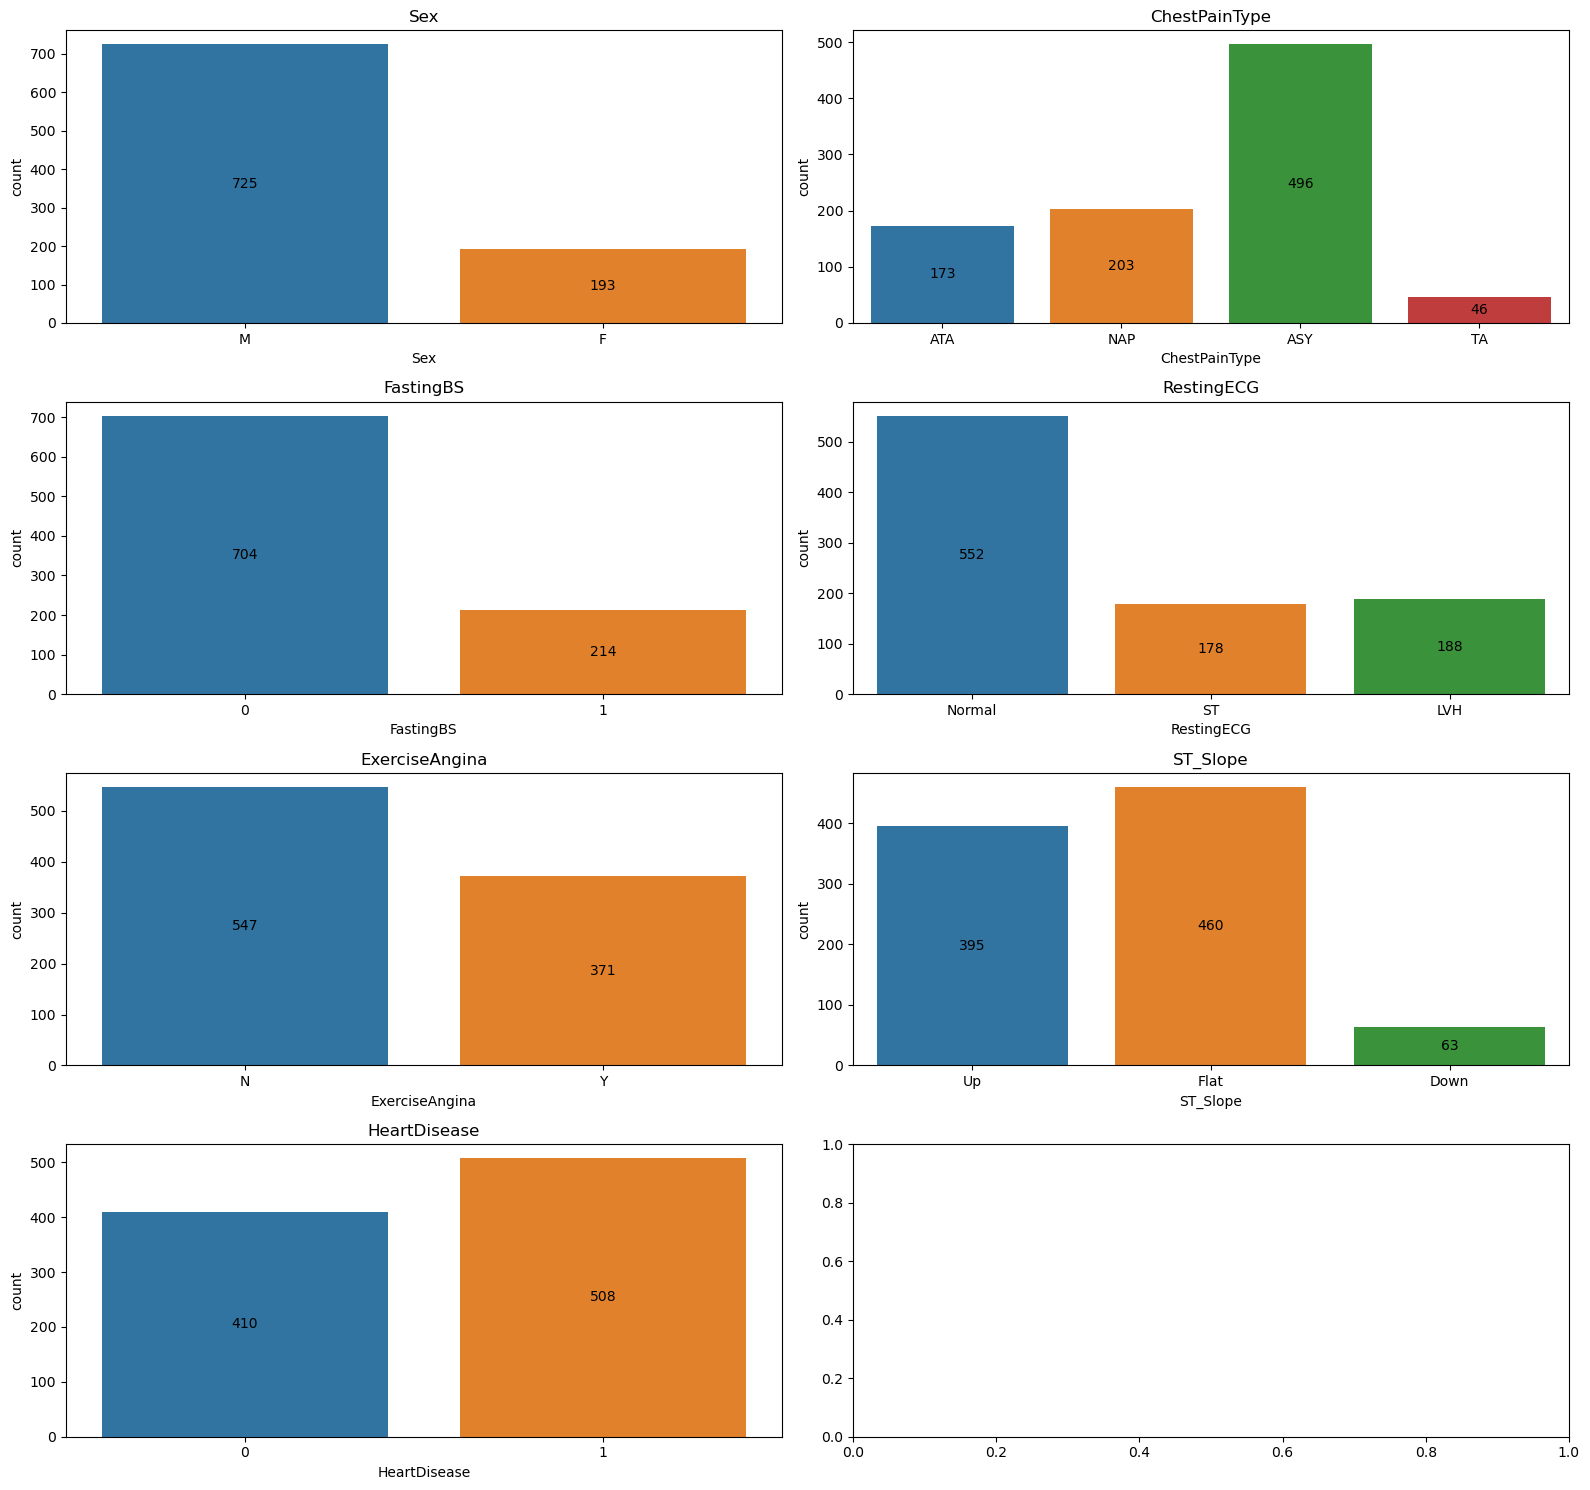

In [41]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig, axes = plt.subplots(4, 2, figsize=(16, 15))
axes = axes.flatten()  

for i, col in enumerate(categorical_cols):
    sns.countplot(x=heart_df[col], ax=axes[i])
    axes[i].set_title(col)
    for container in axes[i].containers:
        axes[i].bar_label(container, label_type="center")

plt.tight_layout()
plt.show()

### Categorical Feature Distribution

The bar plots above show the distribution of categorical features in the dataset. A few key observations can be made:

- **Sex**: The dataset has a higher number of male patients than female patients, which might influence model bias.
- **Chest Pain Type**: The most frequent chest pain type is *ASY* (asymptomatic), which may indicate patients were not experiencing obvious symptoms despite having heart disease.
- **FastingBS (Fasting Blood Sugar > 120 mg/dl)**: Most patients had a fasting blood sugar less than or equal to 120 mg/dl.
- **RestingECG**: The *Normal* ECG category dominates the dataset, followed by *ST* and *LVH*.
- **Exercise-Induced Angina**: More patients did not experience exercise-induced angina (*N*), but the presence of *Y* is still significant.
- **ST Slope**: *Flat* and *Up* slopes are more common than *Down*, with *Down* being relatively rare.
- **HeartDisease**: The number of patients diagnosed with heart disease (label 1) slightly exceeds those without (label 0), which gives a nearly balanced target variable.

These distributions provide insights into the composition of the dataset and help identify potential imbalances or dominant categories that may impact model performance.


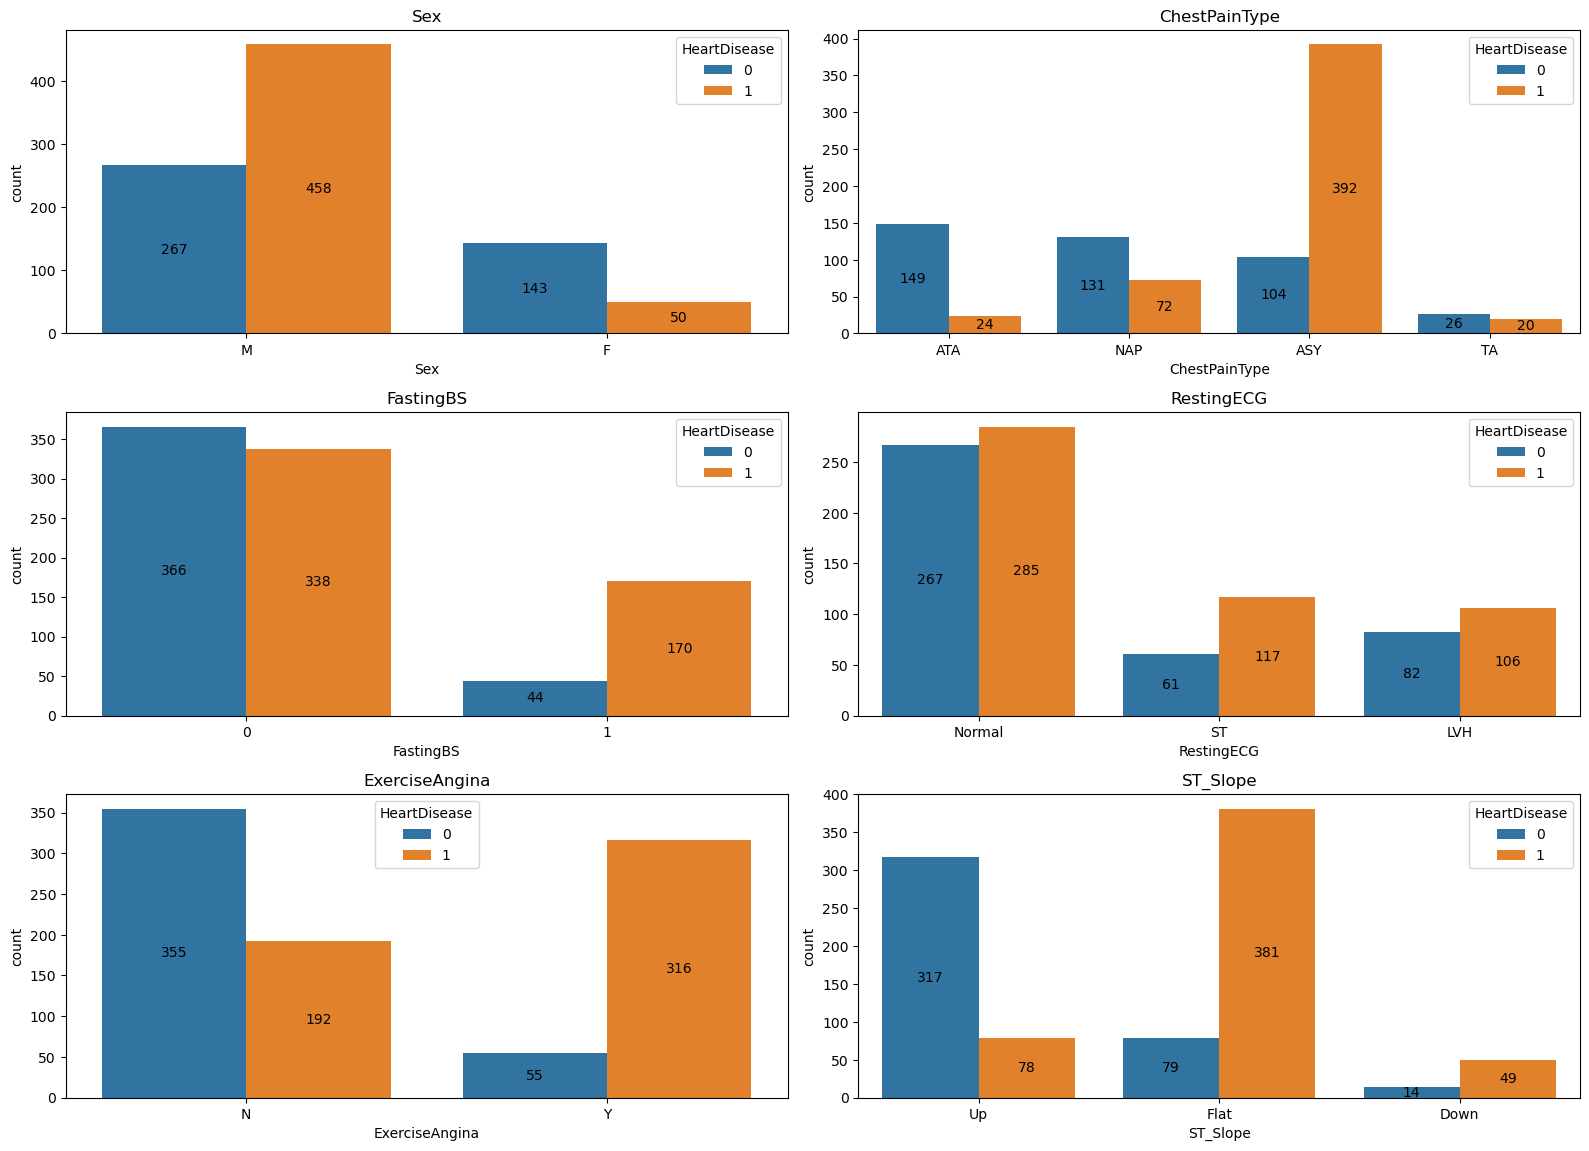

In [43]:
heart_df[categorical_cols] = heart_df[categorical_cols].astype(str)

fig, axes = plt.subplots(4, 2, figsize=(16, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols[:-1]):
    sns.countplot(x=heart_df[col], hue=heart_df['HeartDisease'], ax=axes[i])
    axes[i].set_title(col)

    for container in axes[i].containers:
        axes[i].bar_label(container, label_type="center")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j]) 
    
plt.tight_layout()
plt.show()

### Categorical Feature Distribution by Heart Disease Status

Now, we investigate the variables with the HeartDisease status.

These bar plots compare the distribution of categorical features based on the presence (`1`) or absence (`0`) of heart disease. According to the plots:

- **Sex**: Males are more likely to be diagnosed with heart disease than females in this dataset.
- **ChestPainType**: A large majority of those with *ASY* (asymptomatic) chest pain have heart disease, suggesting this type is a strong indicator.
- **FastingBS**: Patients with high fasting blood sugar (`1`) show a greater proportion of heart disease cases.
- **RestingECG**: The *ST* and *LVH* categories are slightly more common among patients with heart disease compared to the *Normal* category.
- **ExerciseAngina**: Patients who experienced exercise-induced angina (`Y`) are more likely to have heart disease, indicating this is a key risk factor.
- **ST_Slope**: The *Flat* and *Down* slope types are strongly associated with heart disease, while *Up* is more common in patients without heart disease.

This breakdown helps identify which categorical features may be predictive of heart disease and could contribute to a model’s classification performance.


### Data Cleaning 

We saw that there were no missing values earlier, but couple of columns have a value of 0 which make no sense. 

Therefore, we will look into zero values of Cholesterol and RestingBP, and decide what to do with them.

In [47]:
heart_df[heart_df['RestingBP'] == 0]

Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
449   55   M           NAP          0            0         0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope HeartDisease  
449    155              N      1.5     Flat            1

In [48]:
heart_df[heart_df['Cholesterol'] == 0]

Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
293   65   M           ASY        115            0         0     Normal   
294   32   M            TA         95            0         1     Normal   
295   61   M           ASY        105            0         1     Normal   
296   50   M           ASY        145            0         1     Normal   
297   57   M           ASY        110            0         1         ST   
..   ...  ..           ...        ...          ...       ...        ...   
514   43   M           ASY        122            0         0     Normal   
515   63   M           NAP        130            0         1         ST   
518   48   M           NAP        102            0         1         ST   
535   56   M           ASY        130            0         0        LVH   
536   62   M           NAP        133            0         1         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope HeartDisease  
293     93              Y      0.0     Flat            1  
294    127              N      0.7       Up            1  
295    110              Y      1.5       Up            1  
296    139              Y      0.7     Flat            1  
297    131              Y      1.4       Up            1  
..     ...            ...      ...      ...          ...  
514    120              N      0.5       Up            1  
515    160              N      3.0     Flat            0  
518    110              Y      1.0     Down            1  
535    122              Y      1.0     Flat            1  
536    119              Y      1.2     Flat            1  

[172 rows x 12 columns]

There is only one zero value for **RestingBP** so we can just delete that value. However, there are 172 zero values for the **Cholesterol**. That's a really high number to remove from the dataset. 

We will continue with changing the zero values in **Cholesterol** with the **HeartDisease** values. So, we will replace the zero value patients with heart disease with the median of the non-zero values for the patients who have heart disease. And otherwise for the patients who have not the heart disease. 

In [50]:
df_clean = heart_df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [51]:
df_clean[["Cholesterol", "RestingBP"]].describe()

Cholesterol   RestingBP
count   917.000000  917.000000
mean    240.600872  132.540894
std      54.009298   17.999749
min      85.000000   80.000000
25%     214.000000  120.000000
50%     223.000000  130.000000
75%     267.000000  140.000000
max     603.000000  200.000000

Now, there are no zero values for both of them. The minimum values have changed.

### Feature Selection

After analyzing the EDA, we can now choose some of the features that we can start using:

- Age
- Sex
- ChestPainType
- Cholesterol
- FastingBS

We can look into the feature columns if they related to target column so that it can support us to find the exact features. 

First, we will convert some of the values into dummy variables.

In [52]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

Age  RestingBP  Cholesterol  MaxHR  Oldpeak  Sex_M  ChestPainType_ATA  \
0   40        140          289    172      0.0   True               True   
1   49        160          180    156      1.0  False              False   
2   37        130          283     98      0.0   True               True   
3   48        138          214    108      1.5  False              False   
4   54        150          195    122      0.0   True              False   

   ChestPainType_NAP  ChestPainType_TA  FastingBS_1  RestingECG_Normal  \
0              False             False        False               True   
1               True             False        False               True   
2              False             False        False              False   
3              False             False        False               True   
4               True             False        False               True   

   RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  HeartDisease_1  
0          False             False          False         True           False  
1          False             False           True        False            True  
2           True             False          False         True           False  
3          False              True           True        False            True  
4          False             False          False         True           False

<Axes: >

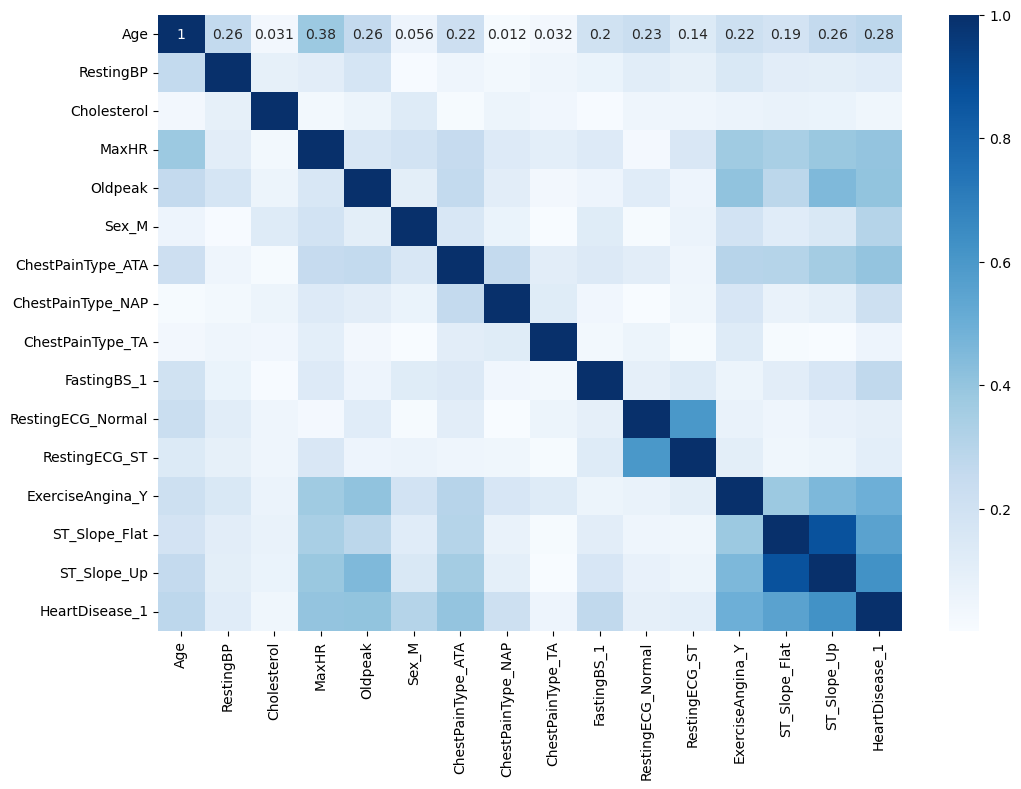

In [53]:
%matplotlib inline
import seaborn as sns 
import matplotlib.pyplot as plt

correlations = abs(df_clean.corr())
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="Blues")

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

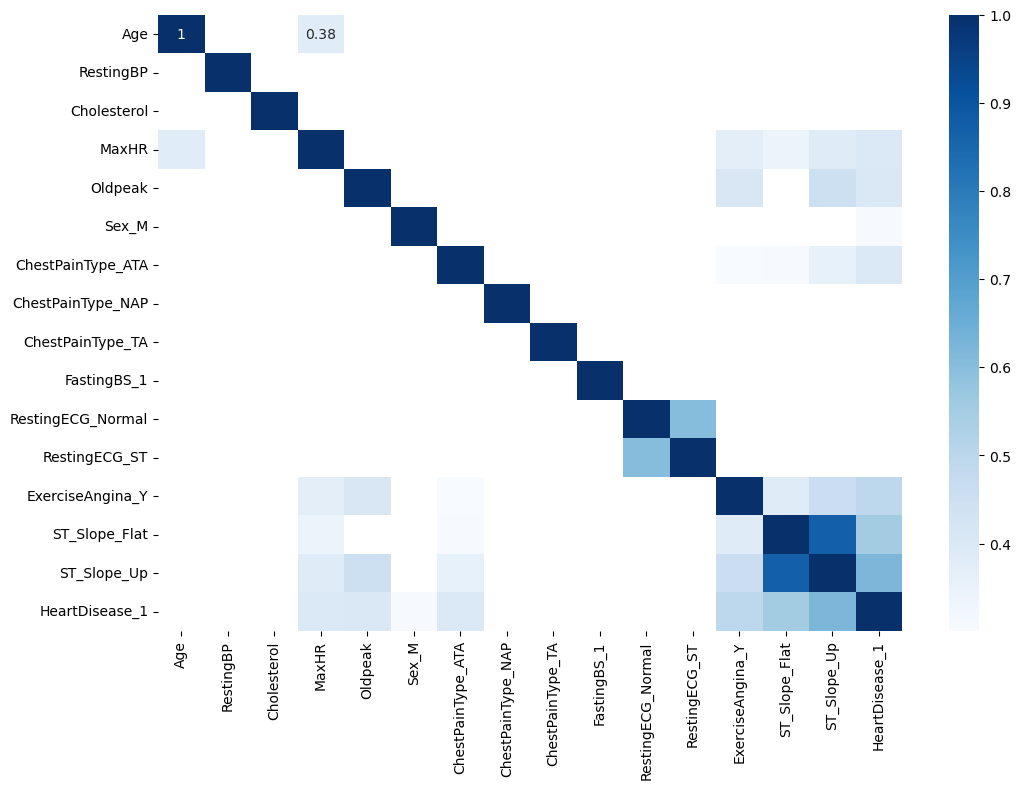

In [54]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")

### Correlation Heatmap Analysis

The correlation heatmap provides insight into the linear relationships between features in the dataset. In the first heatmap, all correlations are shown, revealing relatively weak linear associations among most variables, with only a few pairs showing moderate correlation.

In the second heatmap, we filtered to display **only correlations greater than 0.3**, helping us focus on stronger, more meaningful relationships. For example, 

- "Oldpeak",
- "ST_Slope_Flat",
- "ExerciseAngina_Y"

show notable positive correlations with the presence of heart disease (HeartDisease_1). These variables may be useful indicators in predicting heart disease and could be prioritized in feature selection or model interpretation.

This step helps us reduce noise by identifying the most relevant features and simplifies the model training process, especially in high-dimensional datasets.

Therefore, we can now select the features we want to use such as;

- "Oldpeak",
- "Sex_M" (It has a low value but let's take it for what we observed in EDA),
- - "ExerciseAngina_Y",
- "ST_Slope_Flat",
- "ST_Slope_Up"

Let's now create our model!

### Building a Classifier with One Feature

First, we need to split our dataset into training and test set.

In [55]:
print(df_clean.columns)

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_M',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up', 'HeartDisease_1'],
      dtype='object')


In [56]:
df_clean = df_clean.rename(columns={"HeartDisease_1": "HeartDisease"})

X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

In [57]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 78.26%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 61.59%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 84.06%


According to the results, the set trained on ST_Slope_Flat and ExerciseAngina_Y showed an accuracy with 82%. 

### Building a Classifier with Multiple Features

First, we will normalize the data with MinMaxScaler from Scikit-Learn to scale values between 0 and 1. And we will train the model again.

In [58]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [59]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 84.06


Now, model accuracy is **84%**! This is a good start. Let's see how we can optimize the parameters.

### Hyperparameter Optimization

We will start with preparing the data.

In [60]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

I will use grid search to find the following range of values for a couple of hyparameters. 

- I will use **range of 1 to 20** for k(n_neighbors in scikit-learn),
- Also, two distance metrics - **minkwoski and manhattan**.

In [61]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [62]:
knn_grid.best_score_*100, knn_grid.best_params_

(83.18114143920594, {'metric': 'minkowski', 'n_neighbors': 16})

So, our best model now had an accuracy of 83% with 16 n_neighbors and minkoswki as a distance metric. 

The accuracy of the model is only slightly better. 

### Model Evaluation on Test Set 

First, we need to start with normalize our test set similar to what we did for our training set. 

In [63]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 87.68


Model accuracy got 87%! So, that means 87% of the time, our model predict whether a patient has a risk of heart disease!

However, let's look deeper into data.

In [64]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64


We used Sex as one of our features for training the model.

- X have 724 males and 193 females.
- X_train have 615 males and 164 females.
- X_test have 109 males and 29 females.

It shows that the above datasets have a significantly higher number of male patients than female ones. 

We already told that this could displays a bias because of this imbalance in our dataset and it shows it potentially impacts our model. 

### Conclusion and Next Steps 

The final model was trained using the following features:

-  "Oldpeak",
-  "Sex_M",
-  "ExerciseAngina_Y",
-  "ST_Slope_Flat",
-  "ST_Slope_Up"

and had a test accuracy of 87.68%. However, the limitations for the data shows that the accuracy may not be indicative for a well performing model. 

We could do more to get better results, such as:

- Try collecting more data,
- Explore other algorithms that may result better than k-NN,
- Try different grid search parameters to find optimum hyperparameters,
- Try different feature usage. 